In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Files

TRAIN_PATHS = 'MURA-v1.1/train_image_paths.csv'
TRAIN_LABELS = 'MURA-v1.1/train_labeled_studies.csv'
VALID_PATHS = 'MURA-v1.1/valid_image_paths.csv'
VALID_LABELS = 'MURA-v1.1/valid_labeled_studies.csv'

In [91]:
train_paths_df = pd.read_csv(TRAIN_PATHS, header=None, names=['Path'])
train_labels_df = pd.read_csv(TRAIN_LABELS, header=None, names=['Study', 'Abnormal'])
valid_paths_df = pd.read_csv(VALID_PATHS, header=None, names=['Path'])
valid_labels_df = pd.read_csv(VALID_LABELS, header=None, names=['Study', 'Abnormal'])

In [92]:
pd.set_option('display.max_colwidth', None)
reduced_train_paths_df = train_paths_df.loc[train_paths_df.Path.str.contains('.*image1.png')]
reduced_valid_paths_df = valid_paths_df.loc[valid_paths_df.Path.str.contains('.*image1.png')]
display(reduced_valid_paths_df)

,Path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png
6,MURA-v1.1/valid/XR_WRIST/patient11186/study2_positive/image1.png
9,MURA-v1.1/valid/XR_WRIST/patient11186/study3_positive/image1.png
12,MURA-v1.1/valid/XR_WRIST/patient11187/study1_positive/image1.png
...,...
3185,MURA-v1.1/valid/XR_FINGER/patient11965/study1_negative/image1.png
3186,MURA-v1.1/valid/XR_FINGER/patient11855/study1_negative/image1.png
3187,MURA-v1.1/valid/XR_FINGER/patient11966/study1_negative/image1.png
3190,MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/image1.png


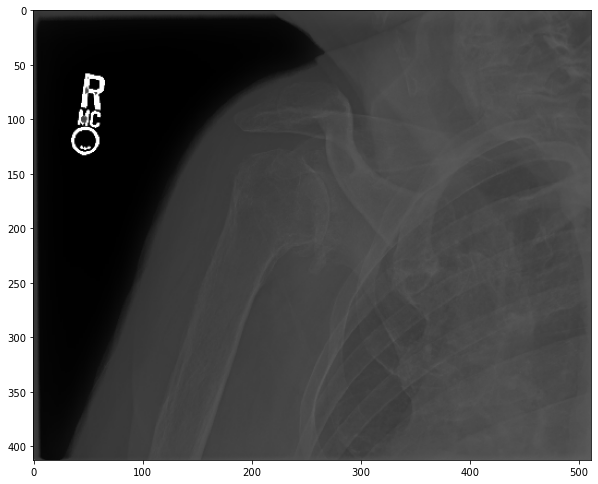

In [93]:
img = cv2.imread(reduced_train_paths_df.iloc[1].Path)
plt.figure(figsize=(10,10))
plt.imshow(img)

In [94]:
start = time.time()

train_images = []
for index, row in reduced_train_paths_df.iterrows():
    train_images.append(cv2.imread(row.Path))
    #train_images.append([[x / 255.0 for x in y] for y in cv2.imread(row.Path)])
    
valid_images = []
for index, row in reduced_valid_paths_df.iterrows():
    valid_images.append(cv2.imread(row.Path))
    #valid_images.append([[x / 255.0 for x in y] for y in cv2.imread(row.Path)])

print(f'{time.time() - start} sec')

101.64087796211243 sec


In [95]:
t_backup = train_images
v_backup = valid_images

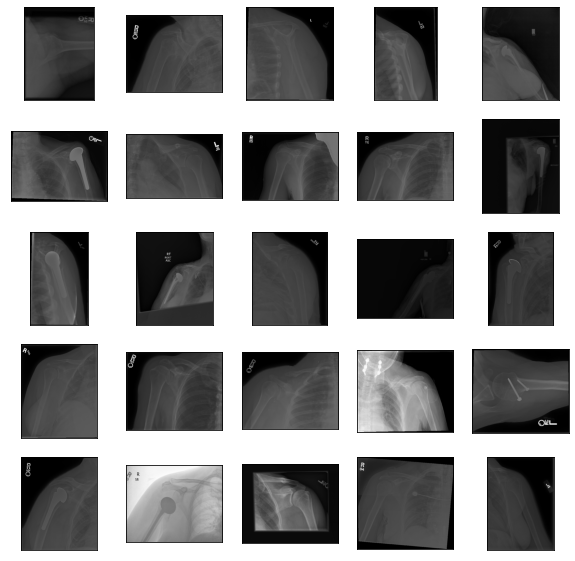

In [96]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [97]:
# find smallest img dimensions

min_x = 999999
min_y = 999999
x_id = -1
y_id = -1

for i in range(len(train_images)):
    sh = train_images[i].shape
    if min_x > sh[0]:
        min_x = sh[0]
        x_id = i
    if min_y > sh[1]:
        min_y = sh[1]
        y_id = i
    
print(x_id, min_x, y_id, min_y)

min_x = 999999
min_y = 999999
x_id = -1
y_id = -1

for i in range(len(valid_images)):
    sh = valid_images[i].shape
    if min_x > sh[0]:
        min_x = sh[0]
        x_id = i
    if min_y > sh[1]:
        min_y = sh[1]
        y_id = i
    
print(x_id, min_x, y_id, min_y)

10700 132 3593 89
271 151 1147 108


In [98]:
# resize images

for i in range(len(train_images)):
    train_images[i] = cv2.resize(train_images[i], (89, 132))

for i in range(len(valid_images)):
    valid_images[i] = cv2.resize(valid_images[i], (89, 132))

In [99]:
train_images[0].shape
valid_images[0].shape

(132, 89, 3)

In [100]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(132, 89, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [101]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [102]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 132, 89, 32)       896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 66, 44, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 21, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 30, 19, 64)        36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 36480)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)              

In [104]:
train_labels = np.array(train_labels_df.Abnormal.tolist())
valid_labels = np.array(valid_labels_df.Abnormal.tolist())

np.reshape(train_images, [-1,132, 89, 3])
np.reshape(valid_images, [-1,132, 89, 3])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(valid_images, valid_labels))

ValueError: Error when checking input: expected conv2d_33_input to have 4 dimensions, but got array with shape (132, 89, 3)